# Make shape datset
We create a synthetic dataset of basic 2D shapes (e.g., circles, triangles, squares) with **no inherent color priors**. 
Each shape is rendered in grayscale and accompanied by a binary foreground mask. 
Foreground and background regions are then colored independently, and simple geometric transformations 
(rotation, scaling, translation) are applied to increase dataset diversity.

## 1. Make basic 2D shapes

In [1]:
import math
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw
from pathlib import Path
import os
import random
from scipy.ndimage import rotate, zoom, shift, binary_erosion
from recolor_images import generate_variants
from plot_variants import show_variants_grid

In [2]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
SHAPES = WORK / "color-concept-entanglement" / "data" / "shapes"

SHAPE_IMGS = SHAPES / "shape_imgs"
SHAPE_MASKS = SHAPES / "shape_masks"
SHAPE_COLORED = SHAPES / "shape_colored"
SHAPES.mkdir(parents=True, exist_ok=True)
SHAPE_IMGS.mkdir(parents=True, exist_ok=True)
SHAPE_MASKS.mkdir(parents=True, exist_ok=True)
SHAPE_COLORED.mkdir(parents=True, exist_ok=True)

In [3]:
def regular_polygon(n_sides, radius, center):
    cx, cy = center
    return [
        (
            cx + radius * math.cos(2 * math.pi * i / n_sides - math.pi / 2),
            cy + radius * math.sin(2 * math.pi * i / n_sides - math.pi / 2),
        )
        for i in range(n_sides)
    ]


def make_shape(
    shape: str,
    size: int = 512,
    line_width: int = 12,
    fg="black",
    bg="white",
):
    """
    Outline via fill–subtract.
    Triangle is slightly thickened for visual consistency.
    """
    img = Image.new("RGB", (size, size), bg)
    draw = ImageDraw.Draw(img)

    center = (size // 2, size // 2)
    outer_r = int(size * 0.35)

    # 🔧 triangle compensation factor
    if shape == "triangle":
        inner_r = outer_r - int(line_width * 1.6)
    else:
        inner_r = outer_r - line_width

    if inner_r <= 0:
        raise ValueError("line_width too large for image size")

    if shape == "circle":
        draw.ellipse(
            [
                center[0] - outer_r,
                center[1] - outer_r,
                center[0] + outer_r,
                center[1] + outer_r,
            ],
            fill=fg,
        )
        draw.ellipse(
            [
                center[0] - inner_r,
                center[1] - inner_r,
                center[0] + inner_r,
                center[1] + inner_r,
            ],
            fill=bg,
        )
    else:
        sides = {
            "triangle": 3,
            "square": 4,
            "pentagon": 5,
            "hexagon": 6,
        }[shape]

        outer = regular_polygon(sides, outer_r, center)
        inner = regular_polygon(sides, inner_r, center)

        draw.polygon(outer, fill=fg)
        draw.polygon(inner, fill=bg)

    return img

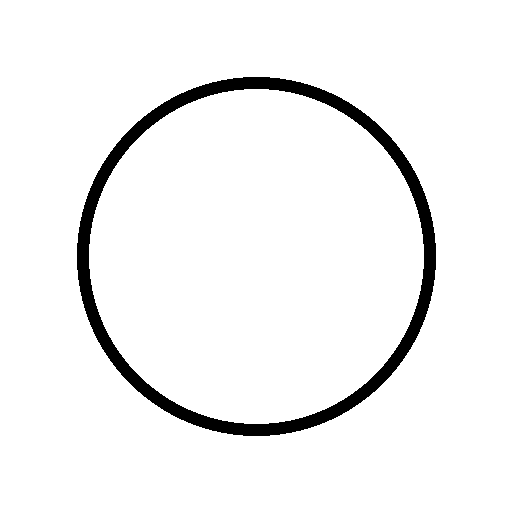

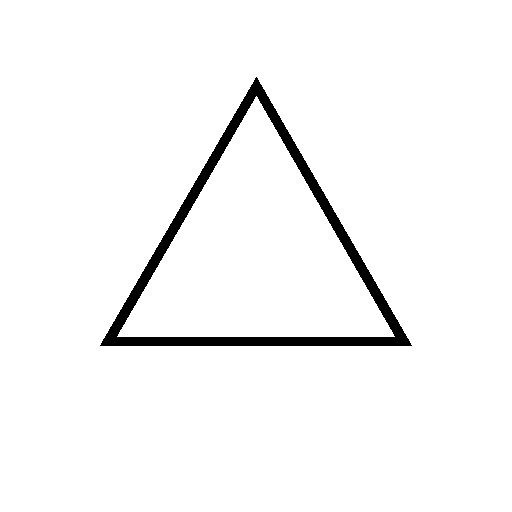

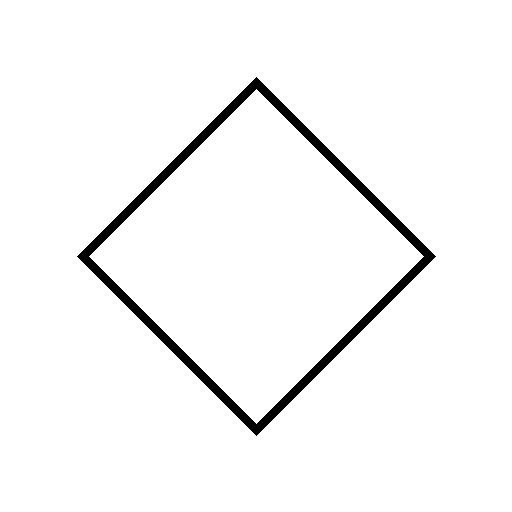

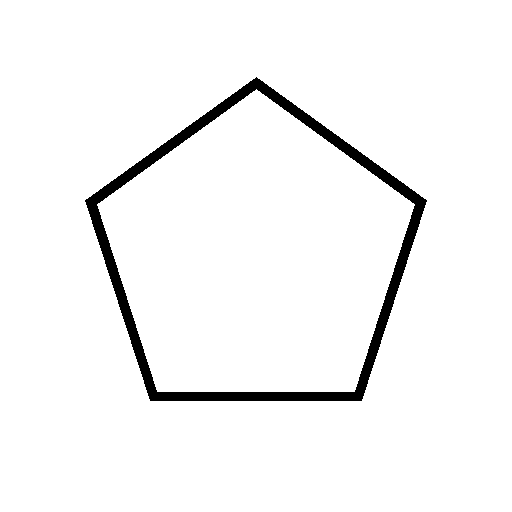

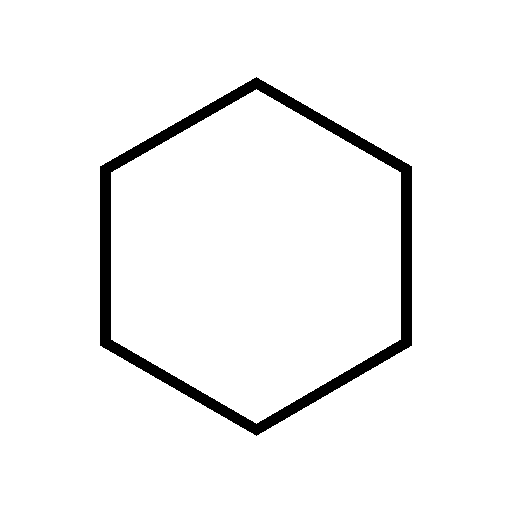

In [4]:
make_shape("circle").show()
make_shape("triangle").show()
make_shape("square").show()
make_shape("pentagon").show()
make_shape("hexagon").show()

## 2. Create mask for each shape 

In [5]:
def make_mask(
    shape: str,
    size: int = 512,
    radius_frac: float = 0.35,
):
    """
    Binary FG mask of the shape (filled).
    """
    img = Image.new("L", (size, size), 0)
    draw = ImageDraw.Draw(img)

    c = size // 2
    r = int(size * radius_frac)

    if shape == "circle":
        draw.ellipse(
            [c - r, c - r, c + r, c + r],
            fill=1,
        )
    else:
        sides = {
            "triangle": 3,
            "square": 4,
            "pentagon": 5,
            "hexagon": 6,
        }[shape]

        points = [
            (
                c + r * math.cos(2 * math.pi * i / sides - math.pi / 2),
                c + r * math.sin(2 * math.pi * i / sides - math.pi / 2),
            )
            for i in range(sides)
        ]
        draw.polygon(points, fill=1)

    return np.array(img, dtype=np.uint8)

In [6]:
def center_crop_or_pad(src, target_shape):
    out = np.zeros(target_shape, dtype=src.dtype)

    sh, sw = src.shape
    th, tw = target_shape

    h = min(sh, th)
    w = min(sw, tw)

    sy = (sh - h) // 2
    sx = (sw - w) // 2
    ty = (th - h) // 2
    tx = (tw - w) // 2

    out[ty:ty+h, tx:tx+w] = src[sy:sy+h, sx:sx+w]
    return out

def sample_transform():
    return dict(
        rotation_deg=random.uniform(0, 360),
        scale=random.uniform(0.7, 1.2),
        translate_xy=(
            random.randint(-50, 50),
            random.randint(-50, 50),
        ),
    )

## 3. Augment shape dataset by simple transformations

In [7]:
def transform_mask(mask, rotation_deg=0.0, scale=1.0, translate_xy=(0, 0)):
    m = mask.astype(float)

    if rotation_deg != 0:
        m = rotate(m, rotation_deg, reshape=False, order=0)

    if scale != 1.0:
        z = zoom(m, scale, order=0)
        m = center_crop_or_pad(z, mask.shape)

    if translate_xy != (0, 0):
        m = shift(
            m,
            shift=(translate_xy[1], translate_xy[0]),
            order=0,
            mode="constant",
            cval=0,
        )

    return m > 0.5

def mask_to_outline(mask, thickness_px):
    eroded = binary_erosion(mask, iterations=thickness_px)
    return mask ^ eroded


def render_outline(mask, outline_thickness=12):
    outline = mask_to_outline(mask, outline_thickness)
    img = np.ones(mask.shape, dtype=np.uint8) * 255
    img[outline] = 0
    return Image.fromarray(img)

In [8]:
def shape_augmentation(
    shapes,
    size=512,
    n_variants=5,
    outline_thickness=12,
    show=False,
):  
    rows = []

    for shape in shapes:
        print(f"\n=== {shape.upper()} ===")

        base_mask = make_mask(shape, size=size)
        base_fg = base_mask.sum()
        print(f"Base FG pixels: {base_fg}")

        for v in range(n_variants):
            params = sample_transform()
            mask = transform_mask(base_mask, **params)
            img = render_outline(mask, outline_thickness)

            name = f"{shape}_v{v:01d}.png"
            mask_name = f"{shape}_v{v:01d}_mask.png"

            img_path = SHAPE_IMGS / name
            mask_path = SHAPE_MASKS / mask_name

            img.save(img_path)
            Image.fromarray(mask.astype("uint8") * 255).save(mask_path)

            fg = mask.sum()
            print(
                f"  variant {v:01d} | "
                f"rot={params['rotation_deg']:.1f}° "
                f"scale={params['scale']:.3f} "
                f"shift={params['translate_xy']} "
                f"FG={fg}"
            )

            rows.append(
                {
                    "object": f"{shape}_v{v:01d}",
                    "shape": shape,
                    "image_path": str(img_path),
                    "cv_mask_path": str(mask_path),
                }
            )

            if show:
                img.show()
    shape_df = pd.DataFrame(rows)
    shape_df.to_csv(SHAPES / "shape_dataset.csv", index=False)

    return shape_df


=== CIRCLE ===
Base FG pixels: 101181
  variant 0 | rot=251.0° scale=0.886 shift=(-28, 32) FG=79553


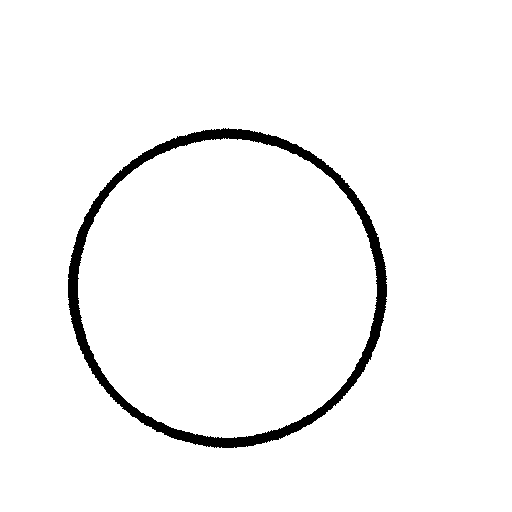

  variant 1 | rot=335.3° scale=0.739 shift=(-35, -5) FG=55086


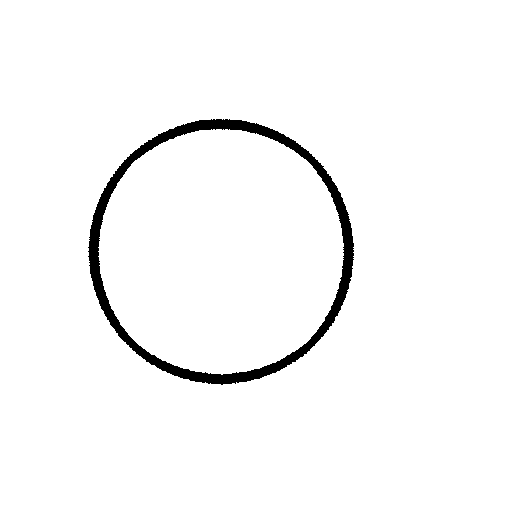

  variant 2 | rot=222.1° scale=0.825 shift=(44, -46) FG=68641


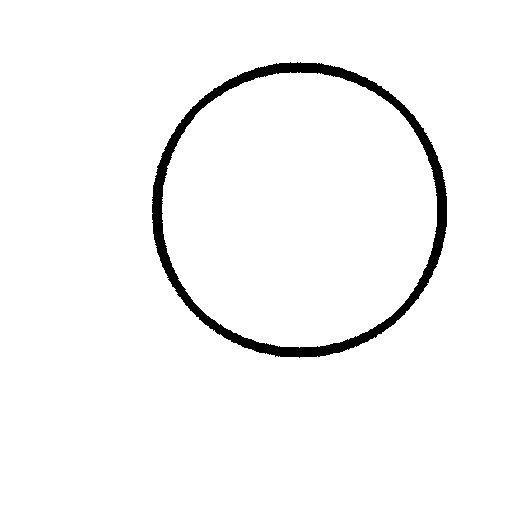

  variant 3 | rot=287.1° scale=0.992 shift=(47, 2) FG=99833


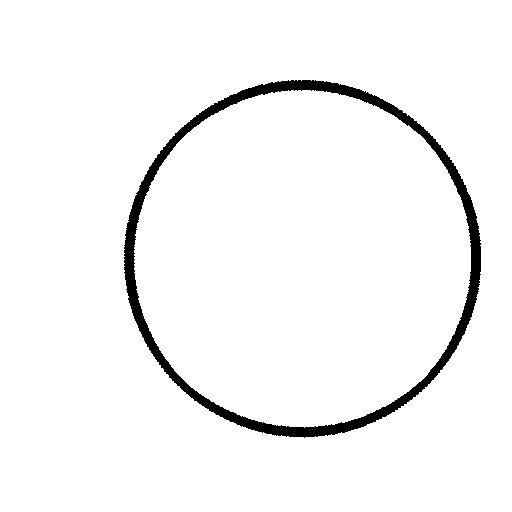

  variant 4 | rot=82.3° scale=1.139 shift=(-24, 4) FG=131268


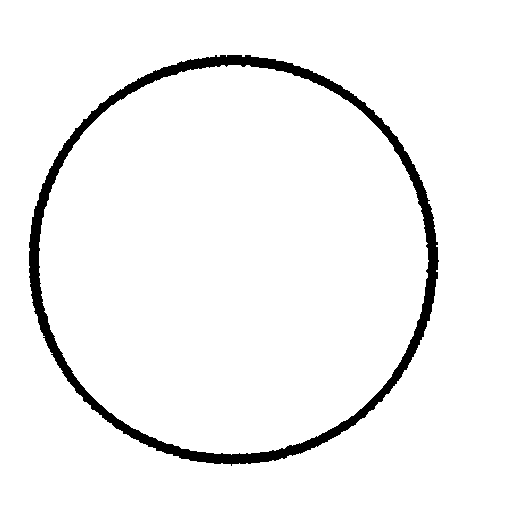


=== TRIANGLE ===
Base FG pixels: 42098
  variant 0 | rot=224.6° scale=0.784 shift=(33, -23) FG=25798


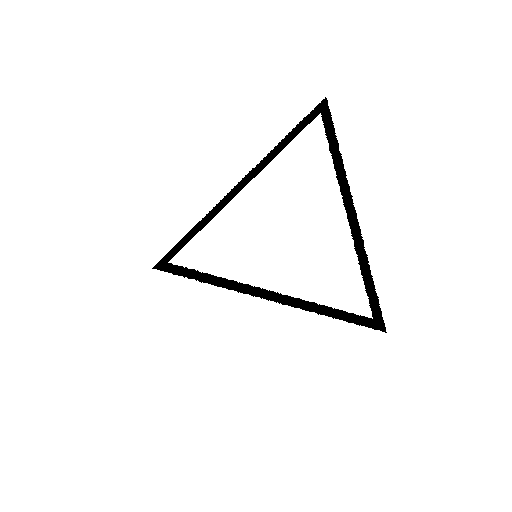

  variant 1 | rot=357.6° scale=0.826 shift=(21, 31) FG=28720


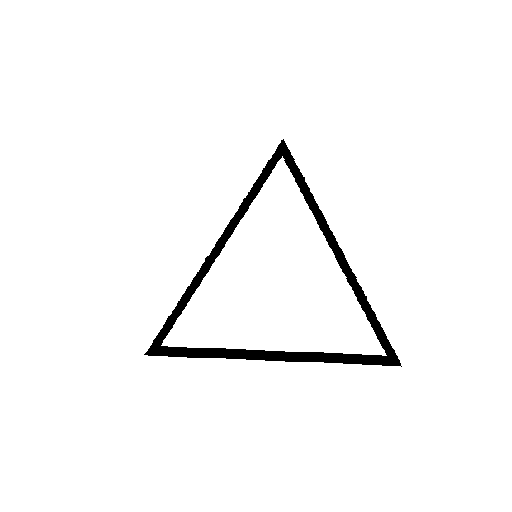

  variant 2 | rot=300.8° scale=1.077 shift=(-20, -13) FG=48649


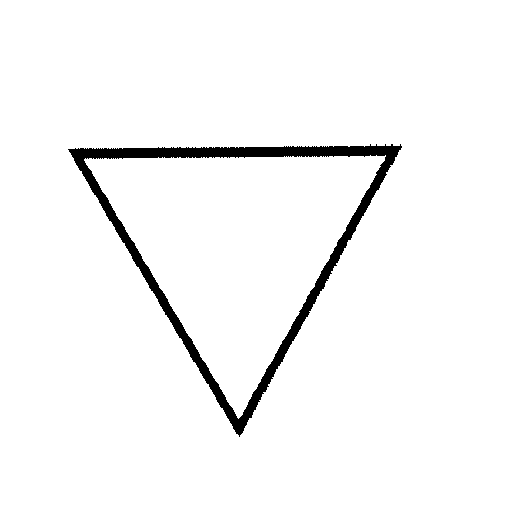

  variant 3 | rot=120.1° scale=1.060 shift=(28, -16) FG=47355


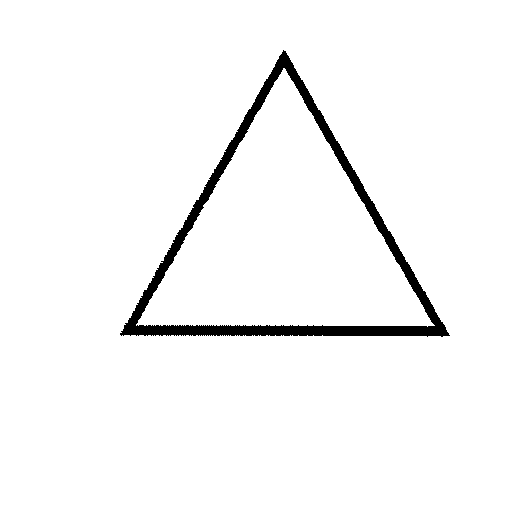

  variant 4 | rot=247.0° scale=0.712 shift=(35, 49) FG=21358


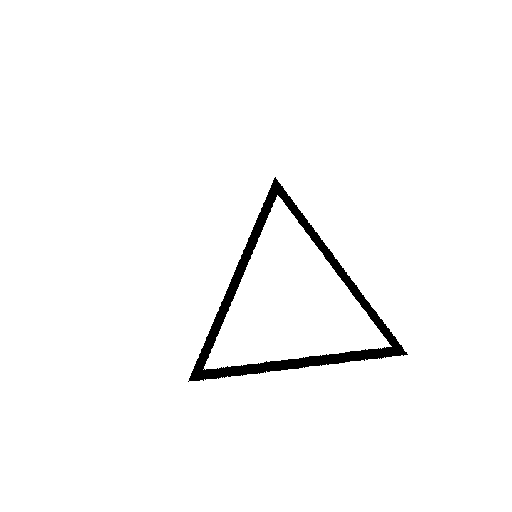


=== SQUARE ===
Base FG pixels: 64441
  variant 0 | rot=305.0° scale=1.046 shift=(6, -38) FG=70628


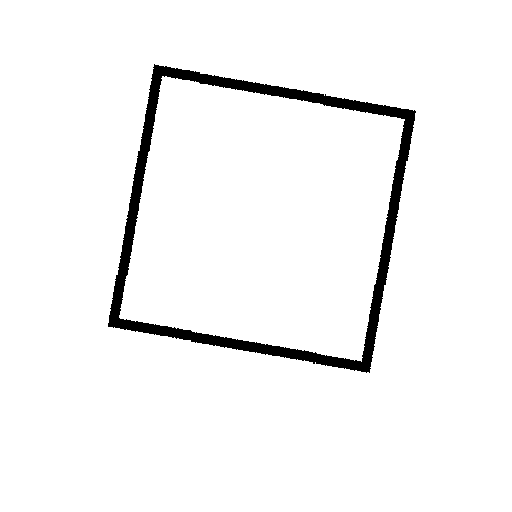

  variant 1 | rot=109.4° scale=0.958 shift=(-23, 28) FG=59267


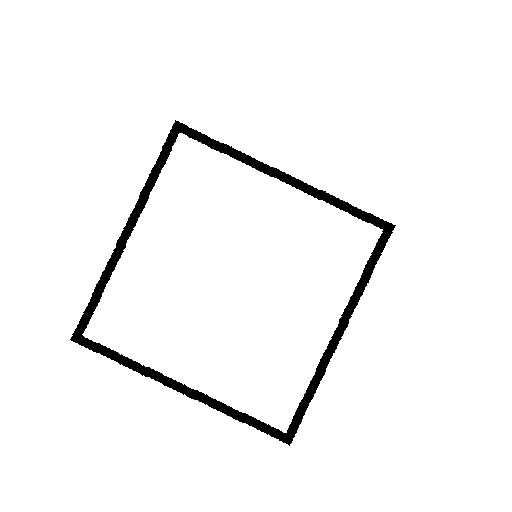

  variant 2 | rot=25.2° scale=0.753 shift=(-6, -2) FG=36596


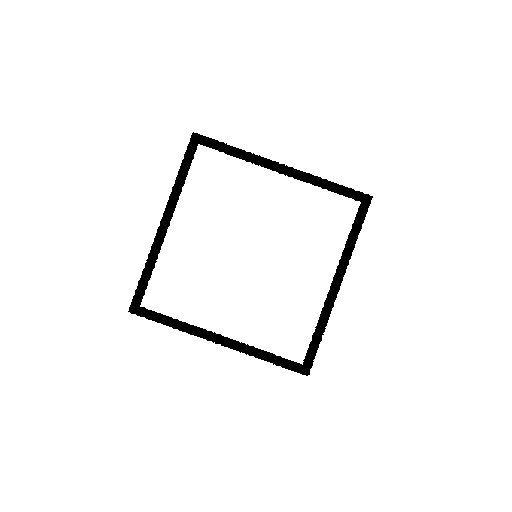

  variant 3 | rot=325.8° scale=1.096 shift=(-2, 32) FG=77379


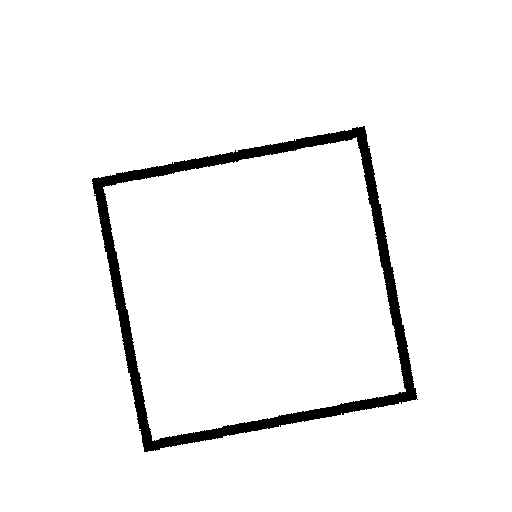

  variant 4 | rot=126.6° scale=1.093 shift=(-15, 3) FG=76852


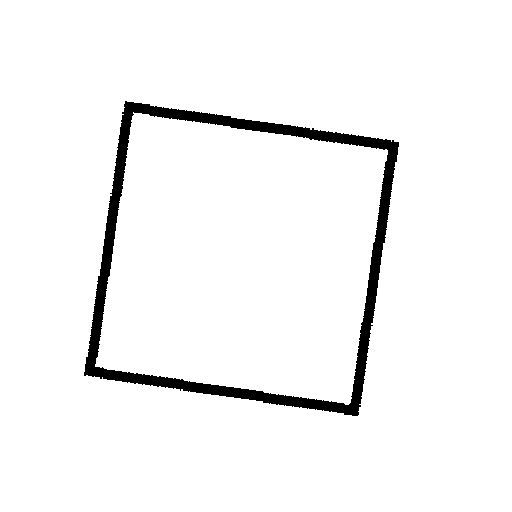


=== PENTAGON ===
Base FG pixels: 76596
  variant 0 | rot=354.2° scale=1.135 shift=(21, -40) FG=98686


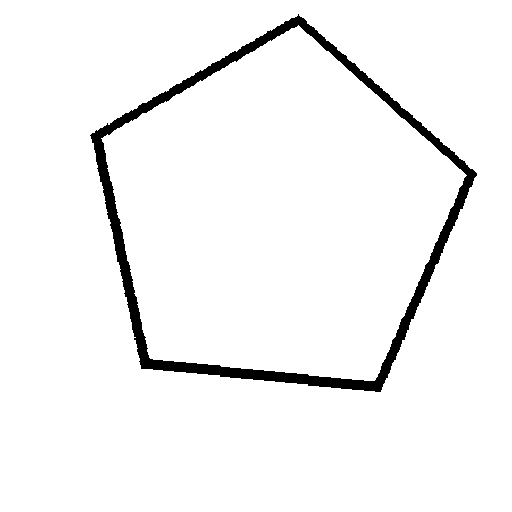

  variant 1 | rot=52.4° scale=1.017 shift=(-43, 49) FG=79299


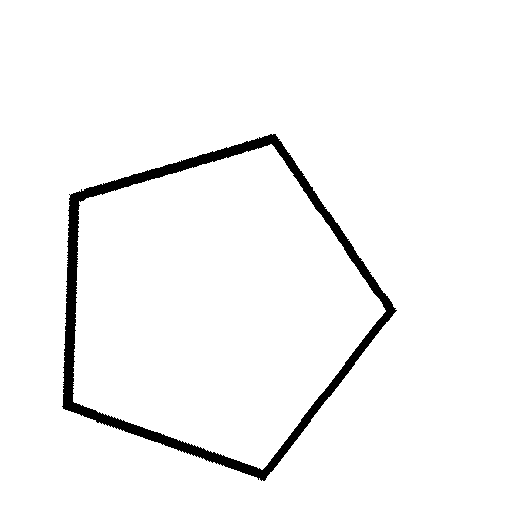

  variant 2 | rot=4.0° scale=0.996 shift=(34, 28) FG=75893


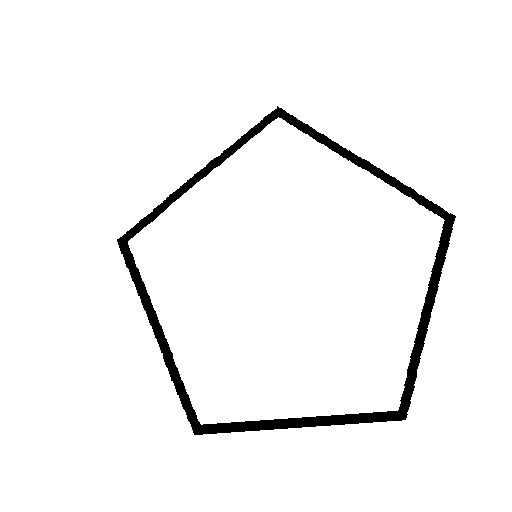

  variant 3 | rot=212.5° scale=0.969 shift=(33, -9) FG=71855


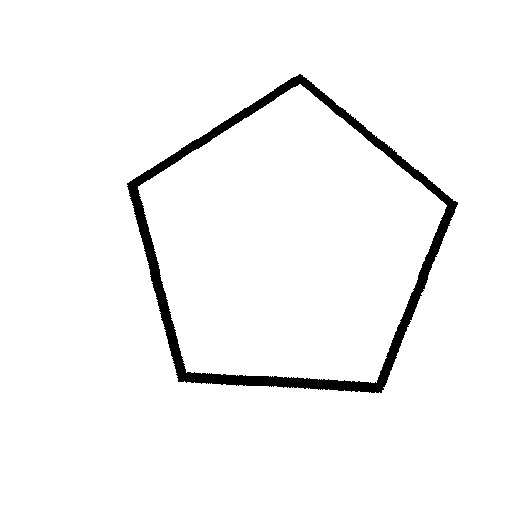

  variant 4 | rot=225.2° scale=0.983 shift=(13, -31) FG=73953


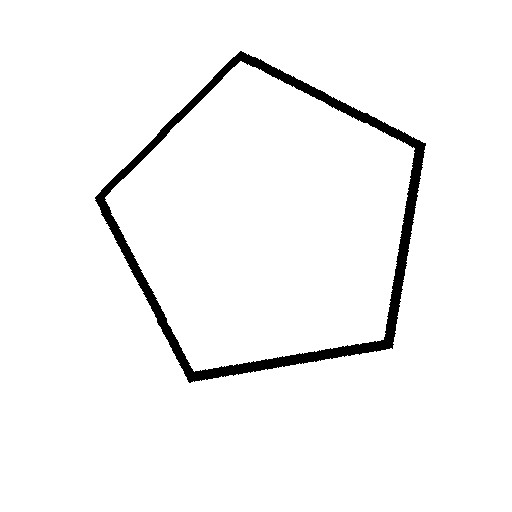


=== HEXAGON ===
Base FG pixels: 83860
  variant 0 | rot=291.6° scale=0.981 shift=(13, -49) FG=80626


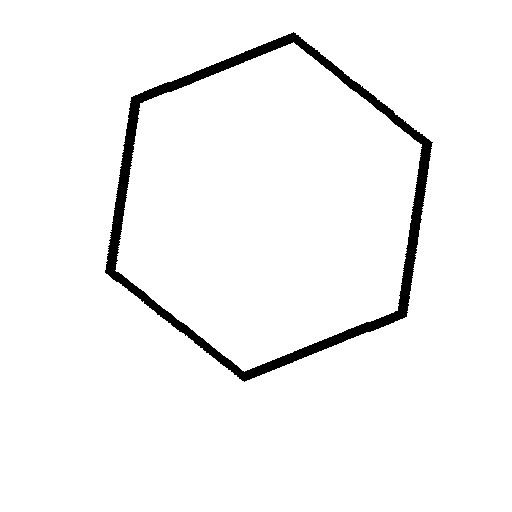

  variant 1 | rot=34.8° scale=1.132 shift=(-27, 42) FG=107666


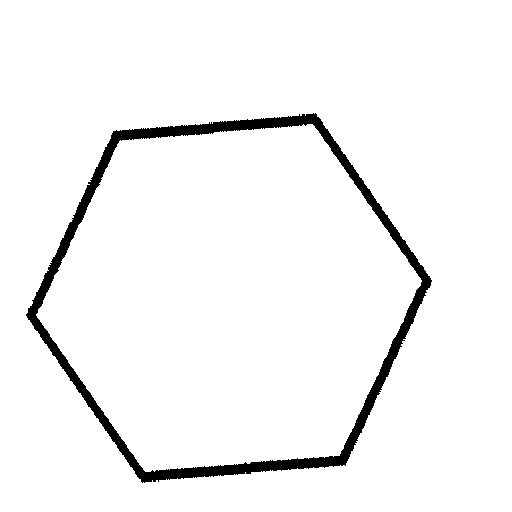

  variant 2 | rot=68.7° scale=0.839 shift=(-27, 17) FG=58827


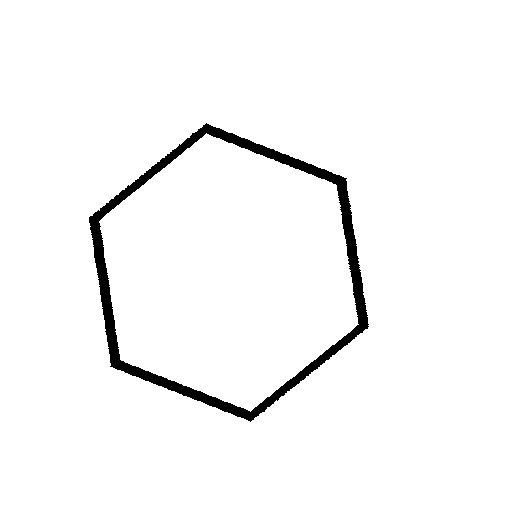

  variant 3 | rot=19.8° scale=0.745 shift=(-3, -34) FG=46376


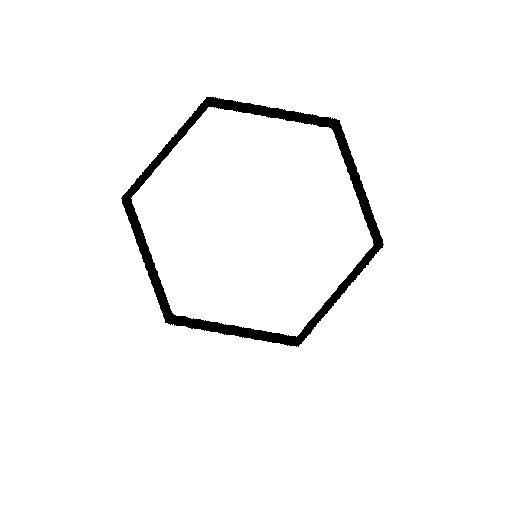

  variant 4 | rot=190.2° scale=1.195 shift=(-38, -9) FG=119867


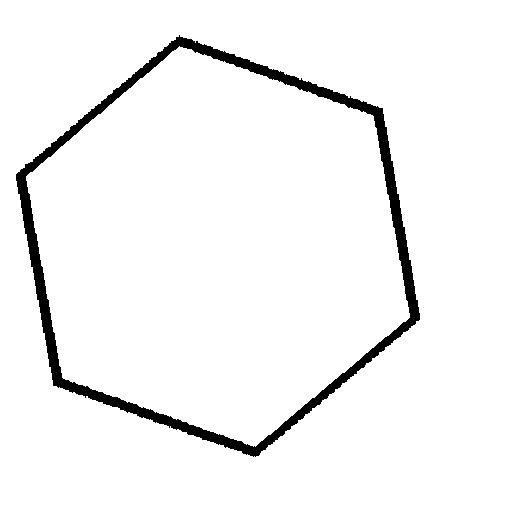

In [9]:
shapes = ["circle", "triangle", "square", "pentagon", "hexagon"]

df = shape_augmentation(
    shapes,
    size=512,
    n_variants=5,
    outline_thickness=10,
    show=True,  # set True to visually inspect
)

## 4. Color shapes and background

In [13]:
# Define custom grid for coloring
pct_schedule = list(range(0, 11, 1)) + list(range(20, 60, 10)) + list([55]) + list(range(60, 110, 10))
print(pct_schedule)

colors = ["red", "brown", "pink", "green", "blue", "yellow", "purple", "orange", "grey", "black"]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 55, 60, 70, 80, 90, 100]


In [14]:
# Generate variants for all images in df
for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating color variants"):
    for color in colors:
        paths = generate_variants(
            row=row,
            target_color=color,
            out_dir=SHAPE_COLORED,
            rng=rng,
            use_patches=True,
            patch_size=16,
            mode="sequential",
            pct_schedule=pct_schedule
        )

Generating color variants:   0%|          | 0/25 [00:00<?, ?it/s]

Generating color variants: 100%|██████████| 25/25 [29:27<00:00, 70.69s/it]


In [15]:
# Define which range of image variants to plot
tail_range = list(range(0, 6)) + list(range(95, 101))
ten_increase = list(range(0, 110, 10))
compact = [0, 10, 50, 90, 100]

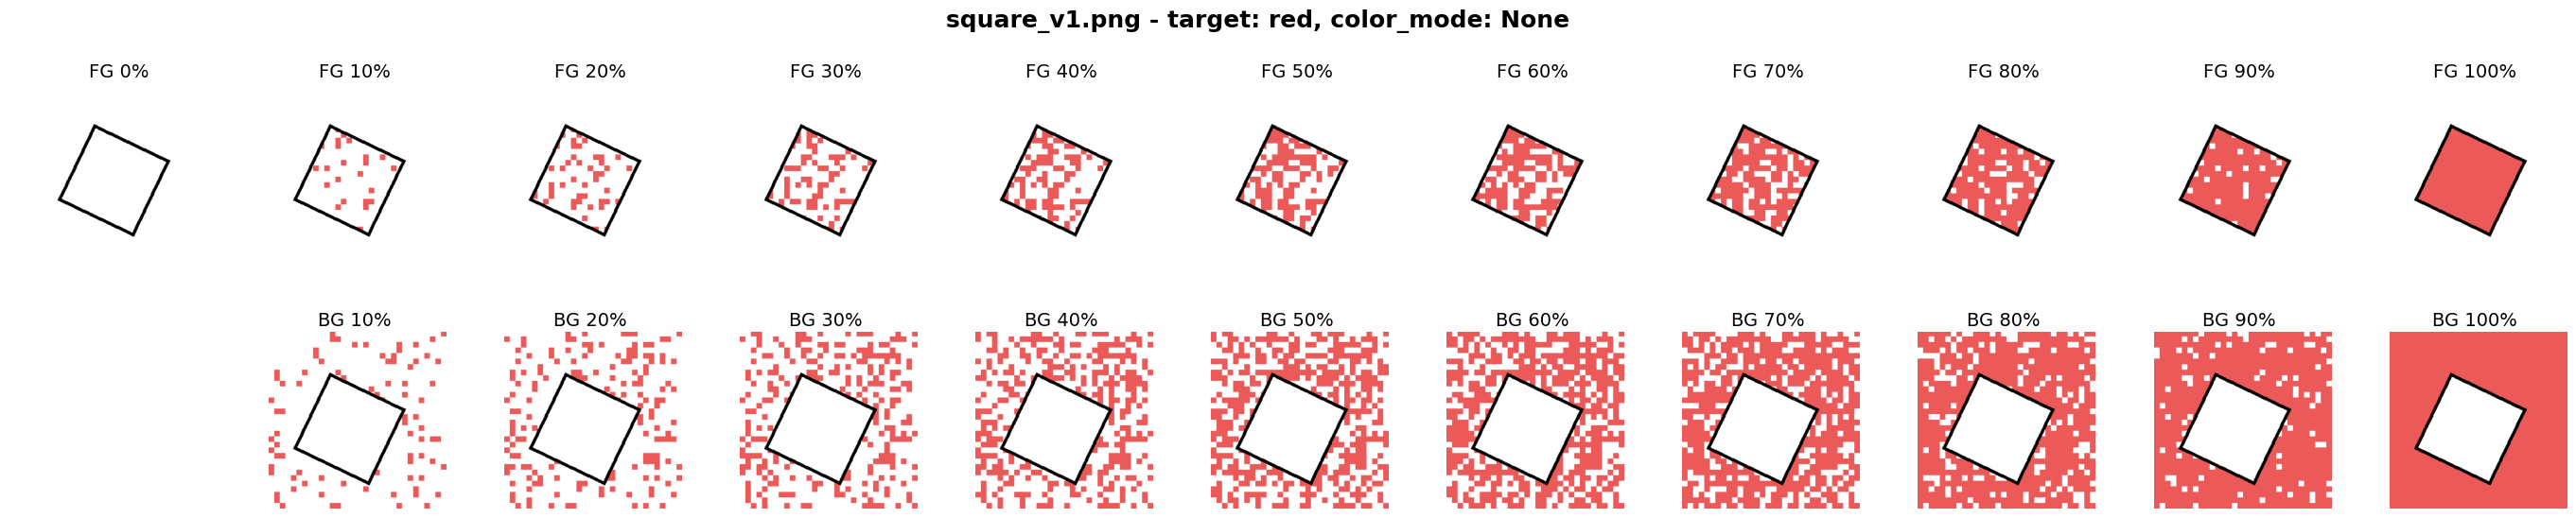

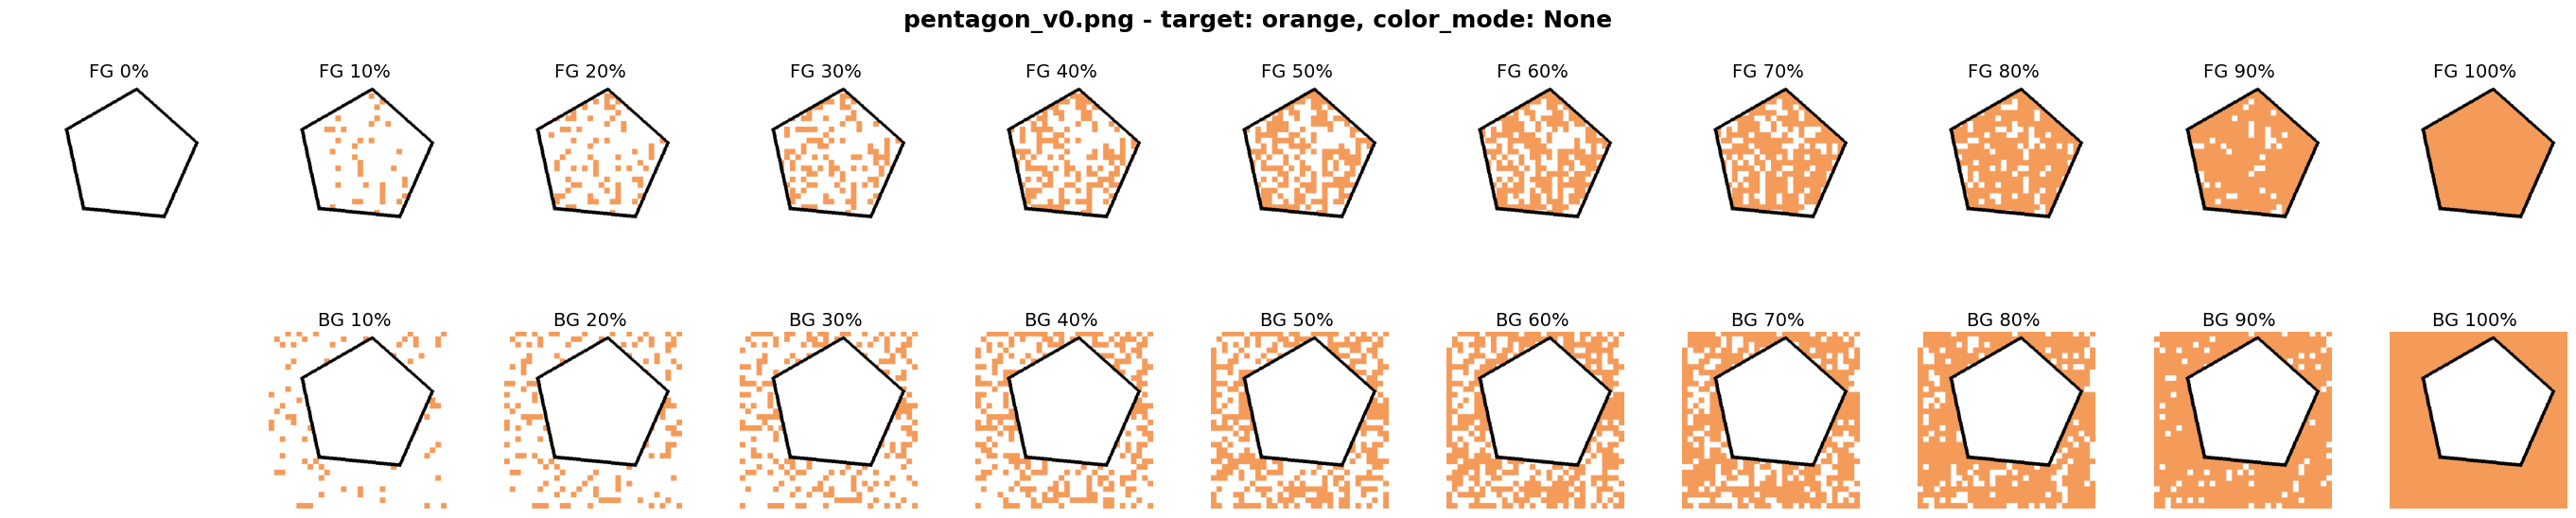

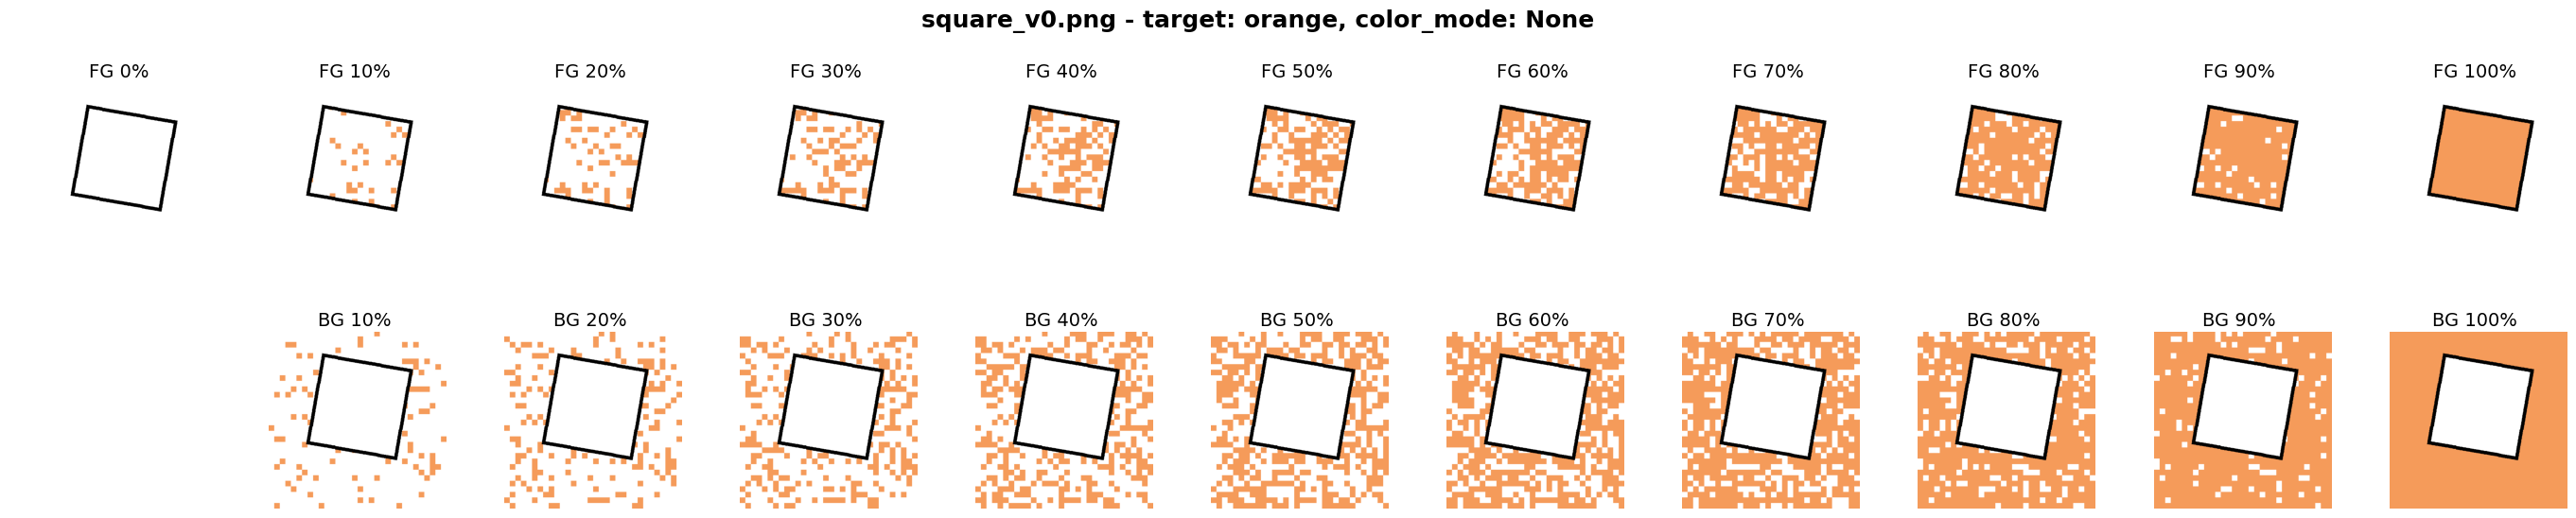

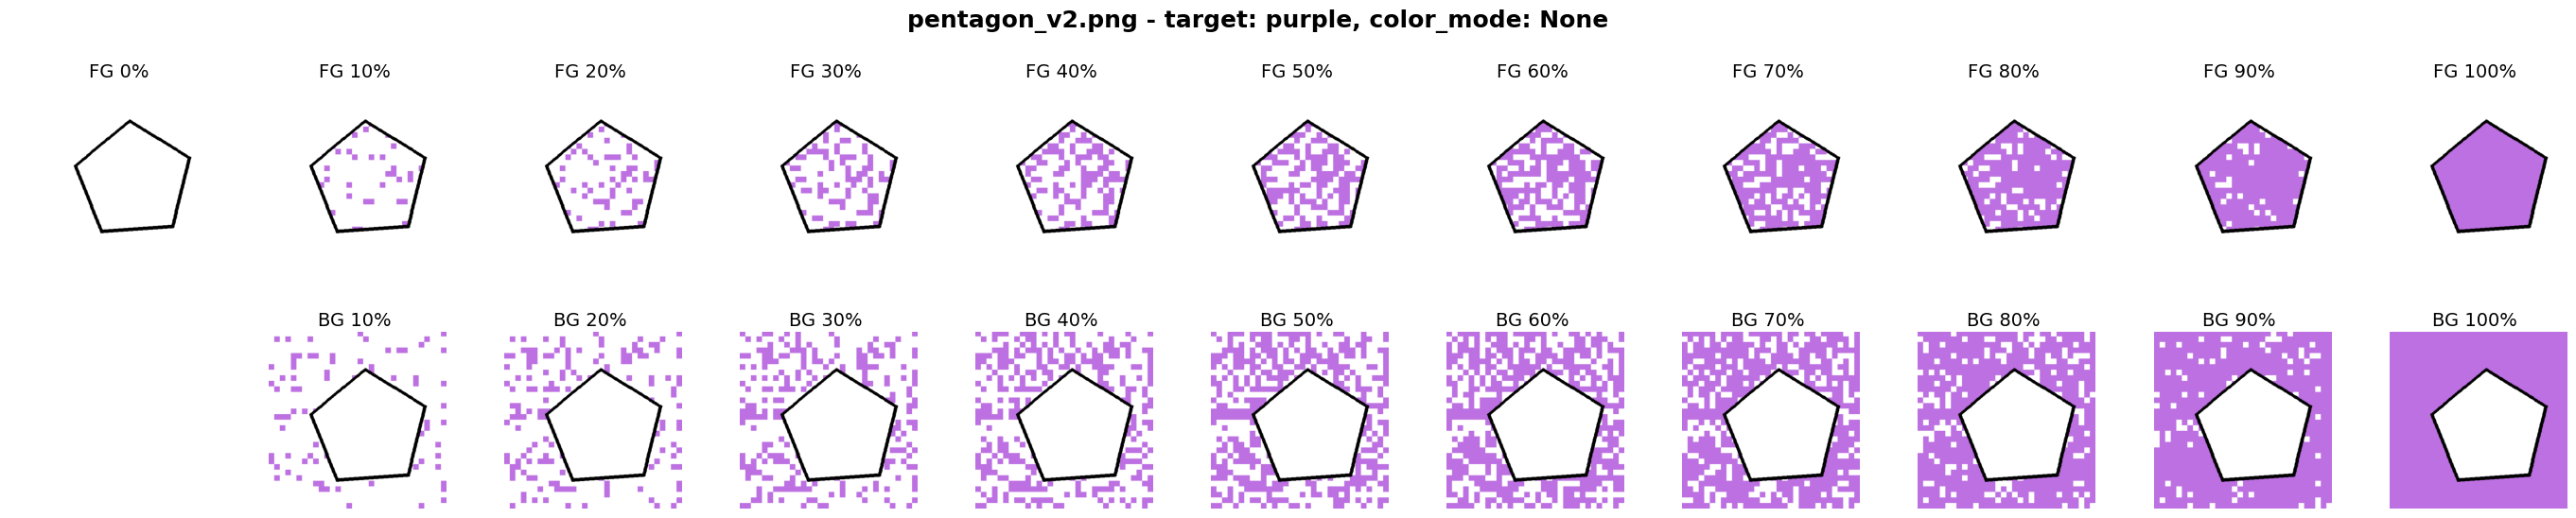

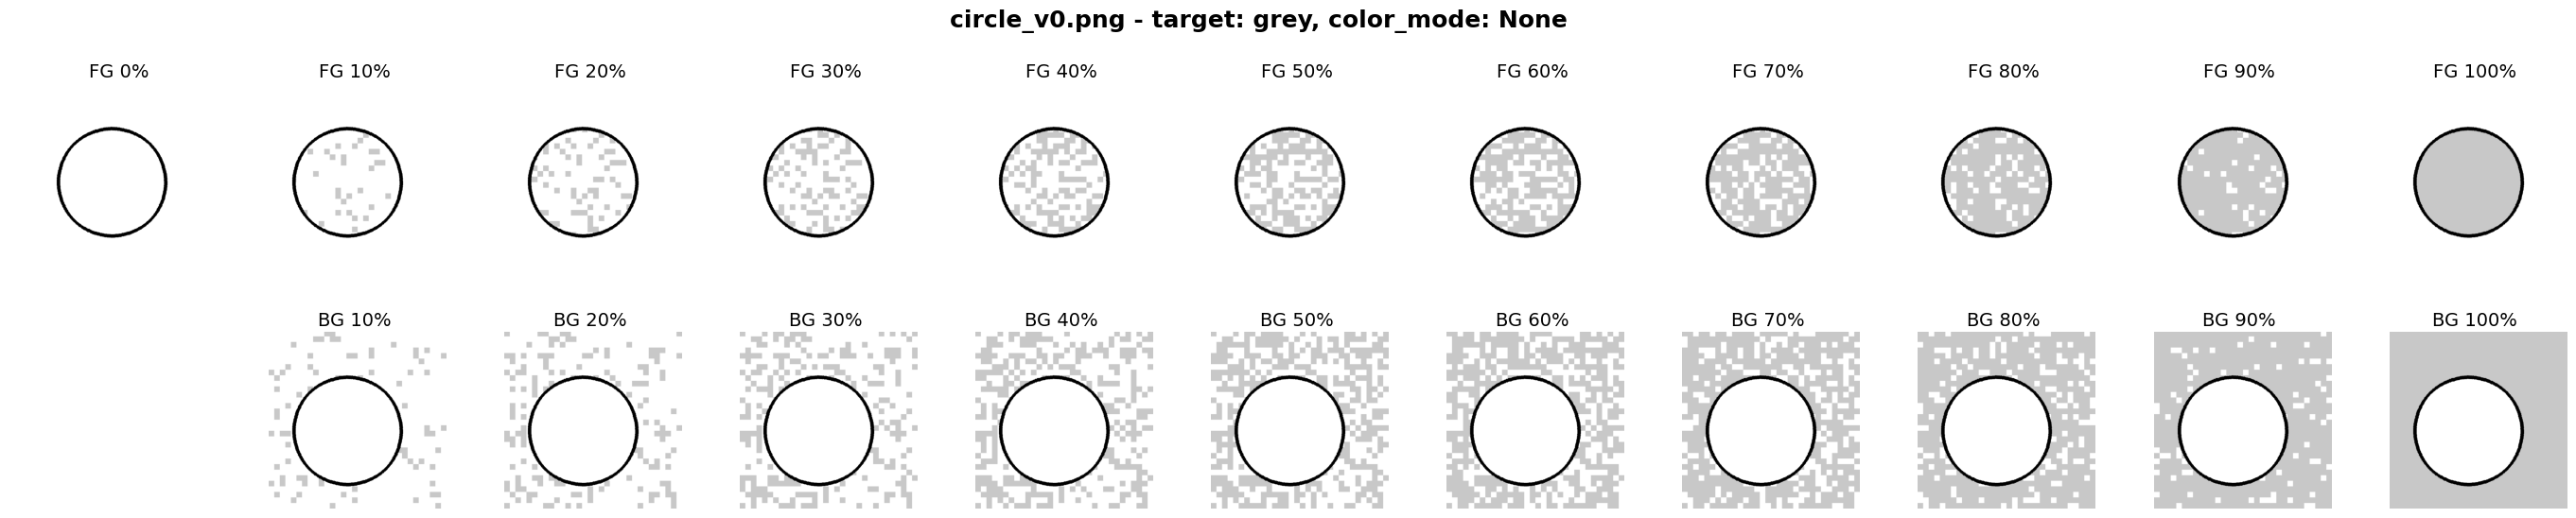

In [16]:
for idx, row in df.sample(5).iterrows():
    c = random.choice(colors)
    show_variants_grid(row['image_path'], c, SHAPE_COLORED, pct_range=ten_increase)